# Tourist Route Planning with Genetic Algorithm - Comprehensive Implementation

This notebook implements dataset generation, GA optimization, baseline comparisons, visualizations, and statistical analysis.

In [1]:
import math, random, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from datetime import datetime
print('Environment ready')

def euclidean(a,b): return math.hypot(a[0]-b[0], a[1]-b[1])
def minutes_to_time_str(minutes):
    base_hour = 9
    h = base_hour + minutes//60
    m = minutes%60
    return f'{int(h):02d}:{int(m):02d}'
def time_str_to_minutes(s):
    h,m=map(int,s.split(':')); return (h-9)*60+m

Environment ready


## Generate Datasets (Hanoi, Da Nang, HCMC)

In [2]:
import random
def generate_attractions_dataset(city_name, num_attractions, grid_size=3.0):
    attraction_types={'Museum':{'base_duration':75,'base_cost':35000,'open_early':True},
                      'Temple':{'base_duration':40,'base_cost':10000,'open_early':True},
                      'Park':{'base_duration':60,'base_cost':0,'open_early':False},
                      'Market':{'base_duration':45,'base_cost':5000,'open_early':True},
                      'Monument':{'base_duration':30,'base_cost':15000,'open_early':True},
                      'Beach':{'base_duration':90,'base_cost':0,'open_early':False},
                      'Shopping':{'base_duration':80,'base_cost':20000,'open_early':True},
                      'Cultural Site':{'base_duration':55,'base_cost':25000,'open_early':True}}
    res=[]; types=list(attraction_types.keys())
    for i in range(1,num_attractions+1):
        x=random.uniform(-grid_size/2,grid_size/2); y=random.uniform(-grid_size/2,grid_size/2)
        t=random.choice(types); td=attraction_types[t]
        if td['open_early']: oh=random.choice([6,7,8]); ch=random.choice([17,18,19])
        else: oh=random.choice([8,9,10]); ch=random.choice([19,20,21,22])
        if t in ['Park','Beach'] and random.random()<0.3: open_t='00:00'; close_t='23:59'
        else: open_t=f'{oh:02d}:{random.choice([0,30]):02d}'; close_t=f'{ch:02d}:{random.choice([0,30]):02d}'
        duration=td['base_duration']+random.randint(-15,20)
        cost=max(0, td['base_cost']+random.randint(-5000,10000))
        res.append({'id':i,'name':f'{city_name} {t} {i}','coord':(x,y),'open':open_t,'close':close_t,'duration':duration,'cost':cost})
    return res
def make_df(attractions):
    rows=[]
    for a in attractions:
        oh,om=map(int,a['open'].split(':')); ch,cm=map(int,a['close'].split(':'))
        rows.append({'id':a['id'],'name':a['name'],'x':a['coord'][0],'y':a['coord'][1],
                     'open_min':(oh-9)*60+om,'close_min':(ch-9)*60+cm,'duration':a['duration'],'cost':a['cost']})
    import pandas as pd
    return pd.DataFrame(rows)

hanoi_df = make_df(generate_attractions_dataset('Hanoi',20,4.0))
danang_df = make_df(generate_attractions_dataset('Da Nang',15,3.5))
hcmc_df   = make_df(generate_attractions_dataset('HCMC',25,5.0))
print('Datasets: Hanoi',len(hanoi_df),'Da Nang',len(danang_df),'HCMC',len(hcmc_df))

Datasets: Hanoi 20 Da Nang 15 HCMC 25


## Genetic Algorithm (Enhanced)

In [3]:

import time
import numpy as np
import random

class EnhancedTRP_GA:
    def __init__(self, df, city_name, budget, hotel=(0,0), population_size=80, generations=120, crossover_p=0.85, mutation_p=0.15, seed=42):
        self.df=df; self.city_name=city_name; self.hotel=hotel; self.budget=budget
        self.pop_size=population_size; self.generations=generations; self.cx_p=crossover_p; self.mut_p=mutation_p
        self.rng=random.Random(seed)
        self.attraction_ids=list(df['id'])
        self.coord={r.id:(r.x,r.y) for r in df.itertuples()}
        self.open_min={r.id:r.open_min for r in df.itertuples()}
        self.close_min={r.id:r.close_min for r in df.itertuples()}
        self.dur={r.id:r.duration for r in df.itertuples()}
        self.cost={r.id:r.cost for r in df.itertuples()}
        self.fitness_history=[]; self.convergence_gen=0; self.execution_time=0
    def eval_route(self, perm):
        t=0; td=0.0; tc=0; feas=True; times=[]; viol={'time':0,'budget':0}; cur=self.hotel
        for aid in perm:
            coord=self.coord[aid]; travel=euclidean(cur,coord)*30; td+=euclidean(cur,coord); t+=travel
            o=self.open_min[aid]; c=self.close_min[aid]
            if t<o: t=o
            if t>c: feas=False; viol['time']+=1; t+=300
            st=t; t+=self.dur[aid]; lv=t; tc+=self.cost[aid]; times.append((aid,st,lv)); cur=coord
        t += euclidean(cur,self.hotel)*30; td+=euclidean(cur,self.hotel)
        if tc>self.budget: feas=False; viol['budget']=tc-self.budget
        fit = td + t/60.0
        if not feas: fit += 5000 + viol['time']*1000 + max(0,viol['budget'])*0.01
        return {'fitness':fit,'total_dist':td,'total_cost':tc,'total_time':t,'route_times':times,'feasible':feas,'violations':viol}
    def nearest_neighbor_heuristic(self):
        unv=self.attraction_ids.copy(); route=[]; cur=self.rng.choice(unv); route.append(cur); unv.remove(cur); curc=self.coord[cur]
        while unv:
            cand=sorted([(a,euclidean(curc,self.coord[a])) for a in unv], key=lambda x:x[1])
            k=min(3,len(cand)); nxt=cand[self.rng.randint(0,k-1)][0]; route.append(nxt); unv.remove(nxt); curc=self.coord[nxt]
        return route
    def cost_based_heuristic(self):
        order=sorted(self.attraction_ids,key=lambda x:self.cost[x]); route=[]; rem=order.copy()
        while rem:
            k=max(1,len(rem)//3); sel=self.rng.choice(rem[:k]); route.append(sel); rem.remove(sel)
        return route
    def initial_pop(self):
        pop=[]
        for _ in range(self.pop_size//2):
            p=self.attraction_ids.copy(); self.rng.shuffle(p); pop.append(p)
        for _ in range(self.pop_size//4): pop.append(self.nearest_neighbor_heuristic())
        for _ in range(self.pop_size//4): pop.append(self.cost_based_heuristic())
        return pop
    def pmx(self,p1,p2):
        n=len(p1); a=self.rng.randint(0,n-2); b=self.rng.randint(a+1,n-1)
        ch=[None]*n; ch[a:b+1]=p1[a:b+1]
        for i in range(n):
            if not (a<=i<=b):
                v=p2[i]
                while v in ch:
                    idx=p2.index(v); v=p1[idx]
                ch[i]=v
        return ch
    def mutate(self,ind):
        if len(ind)>1:
            i,j=self.rng.sample(range(len(ind)),2); ind[i],ind[j]=ind[j],ind[i]
    def tournament(self,pop,scores,k=3):
        ch=self.rng.sample(range(len(pop)),k); return pop[min(ch,key=lambda i:scores[i])]
    def run(self):
        import numpy as np, time
        st=time.time(); pop=self.initial_pop(); best=None; best_score=float('inf'); best_det=None; no_imp=0
        for g in range(self.generations):
            evals=[self.eval_route(ind) for ind in pop]; scores=[e['fitness'] for e in evals]
            mi=int(np.argmin(scores))
            if scores[mi]<best_score:
                best_score=scores[mi]; best=pop[mi].copy(); best_det=evals[mi]; self.convergence_gen=g; no_imp=0
            else: no_imp+=1
            self.fitness_history.append({'generation':g,'best_fitness':best_score,'avg_fitness':float(np.mean(scores)),'worst_fitness':float(np.max(scores))})
            if no_imp>30: break
            new=[]; ord=np.argsort(scores); new.append(pop[int(ord[0])].copy()); new.append(pop[int(ord[1])].copy())
            while len(new)<self.pop_size:
                p1=self.tournament(pop,scores); p2=self.tournament(pop,scores)
                c1=self.pmx(p1,p2) if random.random()<self.cx_p else p1.copy()
                c2=self.pmx(p2,p1) if random.random()<self.cx_p else p2.copy()
                if random.random()<self.mut_p: self.mutate(c1)
                if random.random()<self.mut_p: self.mutate(c2)
                new.append(c1)
                if len(new)<self.pop_size: new.append(c2)
            pop=new
        self.execution_time=time.time()-st
        return {'best_route':best,'best_details':best_det,'fitness_history':self.fitness_history,'convergence_generation':self.convergence_gen,'execution_time':self.execution_time}


## Baselines: Greedy & Random

In [4]:

class GreedyTRP:
    def __init__(self, df, city_name, budget, hotel=(0,0)):
        self.df=df; self.city_name=city_name; self.hotel=hotel; self.budget=budget
        self.attraction_ids=list(df['id'])
        self.coord={r.id:(r.x,r.y) for r in df.itertuples()}
        self.open_min={r.id:r.open_min for r in df.itertuples()}
        self.close_min={r.id:r.close_min for r in df.itertuples()}
        self.dur={r.id:r.duration for r in df.itertuples()}
        self.cost={r.id:r.cost for r in df.itertuples()}
    def _eval(self,perm):
        t=0; td=0.0; tc=0; feas=True; times=[]; viol={'time':0,'budget':0}; cur=self.hotel
        for aid in perm:
            coord=self.coord[aid]; tt=euclidean(cur,coord)*30; td+=euclidean(cur,coord); t+=tt
            o=self.open_min[aid]; c=self.close_min[aid]
            if t<o: t=o
            if t>c: feas=False; viol['time']+=1; t+=300
            st=t; t+=self.dur[aid]; lv=t; tc+=self.cost[aid]; times.append((aid,st,lv)); cur=coord
        t+=euclidean(cur,self.hotel)*30; td+=euclidean(cur,self.hotel)
        if tc>self.budget: feas=False; viol['budget']=tc-self.budget
        fit=td + t/60.0
        if not feas: fit += 5000 + viol['time']*1000 + max(0,viol['budget'])*0.01
        return {'fitness':fit,'total_dist':td,'total_cost':tc,'total_time':t,'route_times':times,'feasible':feas,'violations':viol}
    def run(self):
        import time
        st=time.time(); unv=self.attraction_ids.copy(); route=[]; cur=self.hotel; tc=0
        while unv:
            feas=[aid for aid in unv if tc+self.cost[aid]<=self.budget]
            if not feas: break
            best=min(feas, key=lambda aid: euclidean(cur,self.coord[aid]))
            route.append(best); unv.remove(best); cur=self.coord[best]; tc+=self.cost[best]
        det=self._eval(route) if route else {'fitness':float('inf'),'total_dist':0,'total_cost':0,'total_time':0,'feasible':False,'route_times':[],'violations':{'time':0,'budget':0}}
        return {'best_route':route,'best_details':det,'execution_time':time.time()-st}

class RandomTRP:
    def __init__(self, df, city_name, budget, hotel=(0,0), iterations=2000):
        self.df=df; self.city_name=city_name; self.hotel=hotel; self.budget=budget; self.iterations=iterations
        self.attraction_ids=list(df['id'])
        self.coord={r.id:(r.x,r.y) for r in df.itertuples()}
        self.open_min={r.id:r.open_min for r in df.itertuples()}
        self.close_min={r.id:r.close_min for r in df.itertuples()}
        self.dur={r.id:r.duration for r in df.itertuples()}
        self.cost={r.id:r.cost for r in df.itertuples()}
    def _eval(self,perm):
        t=0; td=0.0; tc=0; feas=True; times=[]; viol={'time':0,'budget':0}; cur=self.hotel
        for aid in perm:
            coord=self.coord[aid]; tt=euclidean(cur,coord)*30; td+=euclidean(cur,coord); t+=tt
            o=self.open_min[aid]; c=self.close_min[aid]
            if t<o: t=o
            if t>c: feas=False; viol['time']+=1; t+=300
            st=t; t+=self.dur[aid]; lv=t; tc+=self.cost[aid]; times.append((aid,st,lv)); cur=coord
        t+=euclidean(cur,self.hotel)*30; td+=euclidean(cur,self.hotel)
        if tc>self.budget: feas=False; viol['budget']=tc-self.budget
        fit=td + t/60.0
        if not feas: fit += 5000 + viol['time']*1000 + max(0,viol['budget'])*0.01
        return {'fitness':fit,'total_dist':td,'total_cost':tc,'total_time':t,'route_times':times,'feasible':feas,'violations':viol}
    def run(self):
        import random, time
        st=time.time(); best=None; best_det=None; best_score=float('inf')
        for _ in range(self.iterations):
            route=self.attraction_ids.copy(); random.shuffle(route); det=self._eval(route)
            if det['fitness']<best_score: best_score=det['fitness']; best=route.copy(); best_det=det
        return {'best_route':best,'best_details':best_det,'execution_time':time.time()-st}


# ALNS

In [5]:
import random, time, math

class ALNS_TRP:
    """
    ALNS tối giản cho TRP với time windows và budget.
    - Biểu diễn nghiệm: permutation toàn bộ điểm
    - Destroy: random removal, worst-removal (gia tăng chi phí), shaw removal (tương tự về không gian)
    - Repair: greedy insertion (incremental fitness), regret-2 insertion
    - Adaptive weights: cập nhật trọng số operator theo kết quả cải thiện
    """
    def __init__(self, df, city_name, budget, hotel=(0,0),
                 iters=2000, init_method='nn', rnd_seed=42,
                 w_scores=(6,3,1), decay=0.8, destroy_rate=(0.1,0.4)):
        self.df = df; self.city = city_name; self.hotel = hotel; self.budget = budget
        self.iters = iters; self.rng = random.Random(rnd_seed)
        self.w1, self.w2, self.w3 = w_scores; self.decay = decay
        self.destroy_rate = destroy_rate
        # maps
        self.ids = list(df['id'])
        self.coord = {r.id: (r.x, r.y) for r in df.itertuples()}
        self.open_min = {r.id: r.open_min for r in df.itertuples()}
        self.close_min = {r.id: r.close_min for r in df.itertuples()}
        self.dur = {r.id: r.duration for r in df.itertuples()}
        self.cost = {r.id: r.cost for r in df.itertuples()}
        # operators
        self.destroy_ops = ['random','worst','shaw']
        self.repair_ops  = ['greedy','regret2']
        self.w_destroy = {op: 1.0 for op in self.destroy_ops}
        self.w_repair  = {op: 1.0 for op in self.repair_ops}

    def dist(self, a, b):
        return math.hypot(a[0]-b[0], a[1]-b[1])

    def eval(self, perm):
        t=0; td=0.0; tc=0; feasible=True; viol={'time':0,'budget':0}; cur=self.hotel
        for aid in perm:
            coord=self.coord[aid]
            travel=self.dist(cur,coord)*30
            td += self.dist(cur,coord)
            t  += travel
            o=self.open_min[aid]; c=self.close_min[aid]
            if t < o: t = o
            if t > c:
                feasible=False; viol['time']+=1; t+=300
            t += self.dur[aid]
            tc += self.cost[aid]
            cur = coord
        t += self.dist(cur, self.hotel)*30
        td += self.dist(cur, self.hotel)
        if tc > self.budget:
            feasible=False; viol['budget']=tc-self.budget
        fit = td + t/60.0
        if not feasible:
            fit += 5000 + viol['time']*1000 + max(0,viol['budget'])*0.01
        return fit, {'fitness':fit,'total_dist':td,'total_cost':tc,'total_time':t,'feasible':feasible,'violations':viol}

    # Initialization
    def initial_solution(self, method='nn'):
        if method=='nn':
            unv=self.ids.copy()
            cur=self.rng.choice(unv); route=[cur]; unv.remove(cur); curc=self.coord[cur]
            while unv:
                cand=sorted([(aid,self.dist(curc,self.coord[aid])) for aid in unv], key=lambda x:x[1])
                k=min(3,len(cand)); nxt=cand[self.rng.randint(0,k-1)][0]
                route.append(nxt); unv.remove(nxt); curc=self.coord[nxt]
            return route
        else:
            route=self.ids.copy(); self.rng.shuffle(route); return route

    # Destroy operators
    def op_random_remove(self, route, q):
        r=route.copy(); rem=self.rng.sample(r, q)
        for x in rem: r.remove(x)
        return r, rem

    def op_worst_remove(self, route, q):
        scores=[]
        for i,aid in enumerate(route):
            prev = (0,0) if i==0 else self.coord[route[i-1]]
            cur  = self.coord[aid]
            nxt  = (0,0) if i==len(route)-1 else self.coord[route[i+1]]
            inc = self.dist(prev,cur)+self.dist(cur,nxt)-self.dist(prev,nxt)
            scores.append((inc, aid))
        scores.sort(reverse=True)
        remove=[aid for _,aid in scores[:q]]
        r=[x for x in route if x not in remove]
        return r, remove

    def op_shaw_remove(self, route, q):
        if not route: return route, []
        r=route.copy(); seed=self.rng.choice(r); removed=[seed]; r.remove(seed)
        def related(a,b): return self.dist(self.coord[a], self.coord[b])
        while len(removed)<q and r:
            cand=sorted([(related(seed,x),x) for x in r], key=lambda x:x[0])
            idx=int(len(cand)**(self.rng.random()))
            pick=cand[idx][1]
            removed.append(pick); r.remove(pick)
        return r, removed

    # Repair operators
    def op_greedy_insert(self, partial, removed):
        r=partial.copy()
        for a in removed:
            best_fit=float('inf'); best_route=None
            for pos in range(len(r)+1):
                tmp=r.copy(); tmp.insert(pos,a)
                fit,_=self.eval(tmp)
                if fit<best_fit: best_fit=fit; best_route=tmp
            r=best_route
        return r

    def op_regret2_insert(self, partial, removed):
        r=partial.copy(); rem=removed.copy()
        while rem:
            best_item=None; best_gain=-float('inf'); best_route=None
            for a in rem:
                scores=[]
                for pos in range(len(r)+1):
                    tmp=r.copy(); tmp.insert(pos,a)
                    fit,_=self.eval(tmp); scores.append((fit,pos,tmp))
                scores.sort(key=lambda x:x[0])
                regret = scores[1][0]-scores[0][0] if len(scores)>=2 else scores[0][0]
                gain = -scores[0][0] + 0.01*regret
                if gain>best_gain:
                    best_gain=gain; best_item=a; best_route=scores[0][2]
            r=best_route; rem.remove(best_item)
        return r

    # Adaptive selection
    def select_op(self, weights):
        ops=list(weights.keys()); vals=[weights[o] for o in ops]
        s=sum(vals); probs=[v/s for v in vals]
        x=self.rng.random(); c=0
        for op,p in zip(ops,probs):
            c+=p
            if x<=c: return op
        return ops[-1]

    def update_weights(self, w, op, outcome):
        reward = {1:self.w1, 2:self.w2, 3:self.w3}.get(outcome, 0)
        w[op] = self.decay*w[op] + (1-self.decay)*reward

    def run(self):
        start=time.time()
        cur = self.initial_solution('nn')
        cur_fit, cur_det = self.eval(cur)
        best=cur.copy(); best_fit=cur_fit; best_det=cur_det
        for it in range(self.iters):
            q = max(1, int(len(cur)* self.rng.uniform(self.destroy_rate[0], self.destroy_rate[1])))
            d_op = self.select_op(self.w_destroy)
            if d_op=='random': partial, removed = self.op_random_remove(cur, q)
            elif d_op=='worst': partial, removed = self.op_worst_remove(cur, q)
            else: partial, removed = self.op_shaw_remove(cur, q)
            r_op = self.select_op(self.w_repair)
            cand = self.op_greedy_insert(partial, removed) if r_op=='greedy' else self.op_regret2_insert(partial, removed)
            cand_fit, cand_det = self.eval(cand)
            accept=False
            if cand_fit < cur_fit:
                accept=True; outcome=2
            else:
                T = max(0.01, 1.0 - it/self.iters)
                if self.rng.random() < math.exp(-(cand_fit-cur_fit)/(1e-6+T)):
                    accept=True; outcome=3
            if accept:
                cur,cur_fit,cur_det=cand,cand_fit,cand_det
                self.update_weights(self.w_destroy, d_op, outcome)
                self.update_weights(self.w_repair,  r_op, outcome)
                if cur_fit < best_fit:
                    best, best_fit, best_det = cur.copy(), cur_fit, cand_det
                    self.update_weights(self.w_destroy, d_op, 1)
                    self.update_weights(self.w_repair,  r_op, 1)
        return {'best_route':best,'best_details':best_det,'execution_time':time.time()-start}


## Run GA on 3 cities

In [6]:

experiments={'Hanoi':(hanoi_df,120000),'Da Nang':(danang_df,180000),'Ho Chi Minh City':(hcmc_df,250000)}
ga_results={}
for city,(df,budget) in experiments.items():
    print(f'Running GA for {city} (n={len(df)}, budget={budget})')
    ga=EnhancedTRP_GA(df, city, budget)
    res=ga.run(); ga_results[city]=res
    det=res['best_details']
    print(f"  best_fitness={det['fitness']:.2f} dist={det['total_dist']:.2f} cost={det['total_cost']:,} time={det['total_time']:.0f} feasible={det['feasible']}")


Running GA for Hanoi (n=20, budget=120000)
  best_fitness=17590.76 dist=21.32 cost=368,587 time=5014 feasible=False
Running GA for Da Nang (n=15, budget=180000)
  best_fitness=10299.58 dist=15.58 cost=203,718 time=2809 feasible=False
Running GA for Ho Chi Minh City (n=25, budget=250000)
  best_fitness=19255.10 dist=26.33 cost=362,591 time=6172 feasible=False


## Compare GA vs Greedy vs Random vs ALNS

In [7]:
comparison_budgets={'Hanoi':400000,'Da Nang':350000,'Ho Chi Minh City':500000}
comparison_results={}
for city, df in {'Hanoi':hanoi_df,'Da Nang':danang_df,'Ho Chi Minh City':hcmc_df}.items():
    budget=comparison_budgets[city]
    print(f"\n=== {city} | budget={budget} ===")
    ga=EnhancedTRP_GA(df, city, budget, population_size=60, generations=100)
    ga_res=ga.run()
    gr=GreedyTRP(df, city, budget).run()
    rd=RandomTRP(df, city, budget, iterations=2000).run()
    al=ALNS_TRP(df, city, budget, iters=2000).run()
    comparison_results[city]={'GA':ga_res,'Greedy':gr,'Random':rd,'ALNS':al}
    for name,res in [('GA',ga_res),('Greedy',gr),('Random',rd),('ALNS',al)]:
        det=res['best_details']
        print(f"{name:7s} | fit={det['fitness']:.1f} | dist={det['total_dist']:.2f} | cost={det['total_cost']:,} | time={res['execution_time']:.3f}s | feas={det['feasible']}")



=== Hanoi | budget=400000 ===
GA      | fit=15101.4 | dist=18.98 | cost=368,587 | time=0.059s | feas=False
Greedy  | fit=18111.9 | dist=16.01 | cost=368,587 | time=0.000s | feas=False
Random  | fit=17138.6 | dist=37.10 | cost=368,587 | time=0.017s | feas=False
ALNS    | fit=14097.4 | dist=19.65 | cost=368,587 | time=1.726s | feas=False

=== Da Nang | budget=350000 ===
GA      | fit=12067.9 | dist=12.55 | cost=203,718 | time=0.039s | feas=False
Greedy  | fit=14079.0 | dist=13.30 | cost=203,718 | time=0.000s | feas=False
Random  | fit=12081.7 | dist=21.81 | cost=203,718 | time=0.013s | feas=False
ALNS    | fit=10059.8 | dist=13.86 | cost=203,718 | time=0.611s | feas=False

=== Ho Chi Minh City | budget=500000 ===
GA      | fit=19133.8 | dist=26.08 | cost=362,591 | time=0.074s | feas=False
Greedy  | fit=23153.1 | dist=25.01 | cost=362,591 | time=0.000s | feas=False
Random  | fit=21200.9 | dist=64.13 | cost=362,591 | time=0.022s | feas=False
ALNS    | fit=17120.4 | dist=23.80 | cost=362,5

## Export CSV/JSON

In [8]:

import pandas as pd, json
rows=[]
for city, algs in comparison_results.items():
    for alg, res in algs.items():
        det=res['best_details']; route=res['best_route'] or []
        rows.append({'City':city,'Algorithm':alg,'Fitness_Score':det['fitness'],'Total_Distance':det['total_dist'],
                     'Total_Cost':det['total_cost'],'Total_Time_Hours':det['total_time']/60.0,'Execution_Time':res['execution_time'],
                     'Attractions_Visited':len(route),'Feasible':det['feasible'],
                     'Distance_Efficiency':det['total_dist']/max(1,len(route)),'Cost_Efficiency':det['total_cost']/max(1,len(route)),
                     'Time_Violations':det['violations']['time'],'Budget_Violation':det['violations']['budget']})
comparison_df=pd.DataFrame(rows)
comparison_df.to_csv('tourist_route_comparison_results.csv', index=False)

detail=[]
for city, algs in comparison_results.items():
    for alg, res in algs.items():
        detail.append({'city':city,'algorithm':alg,'route':res['best_route'],'fitness':res['best_details']['fitness'],
                       'distance':res['best_details']['total_dist'],'cost':res['best_details']['total_cost'],'feasible':res['best_details']['feasible']})
with open('detailed_routes.json','w') as f: json.dump(detail,f,indent=2)
print('Saved tourist_route_comparison_results.csv and detailed_routes.json')


Saved tourist_route_comparison_results.csv and detailed_routes.json


## Visualize Best Routes

Saved tourist_route_visualizations.png


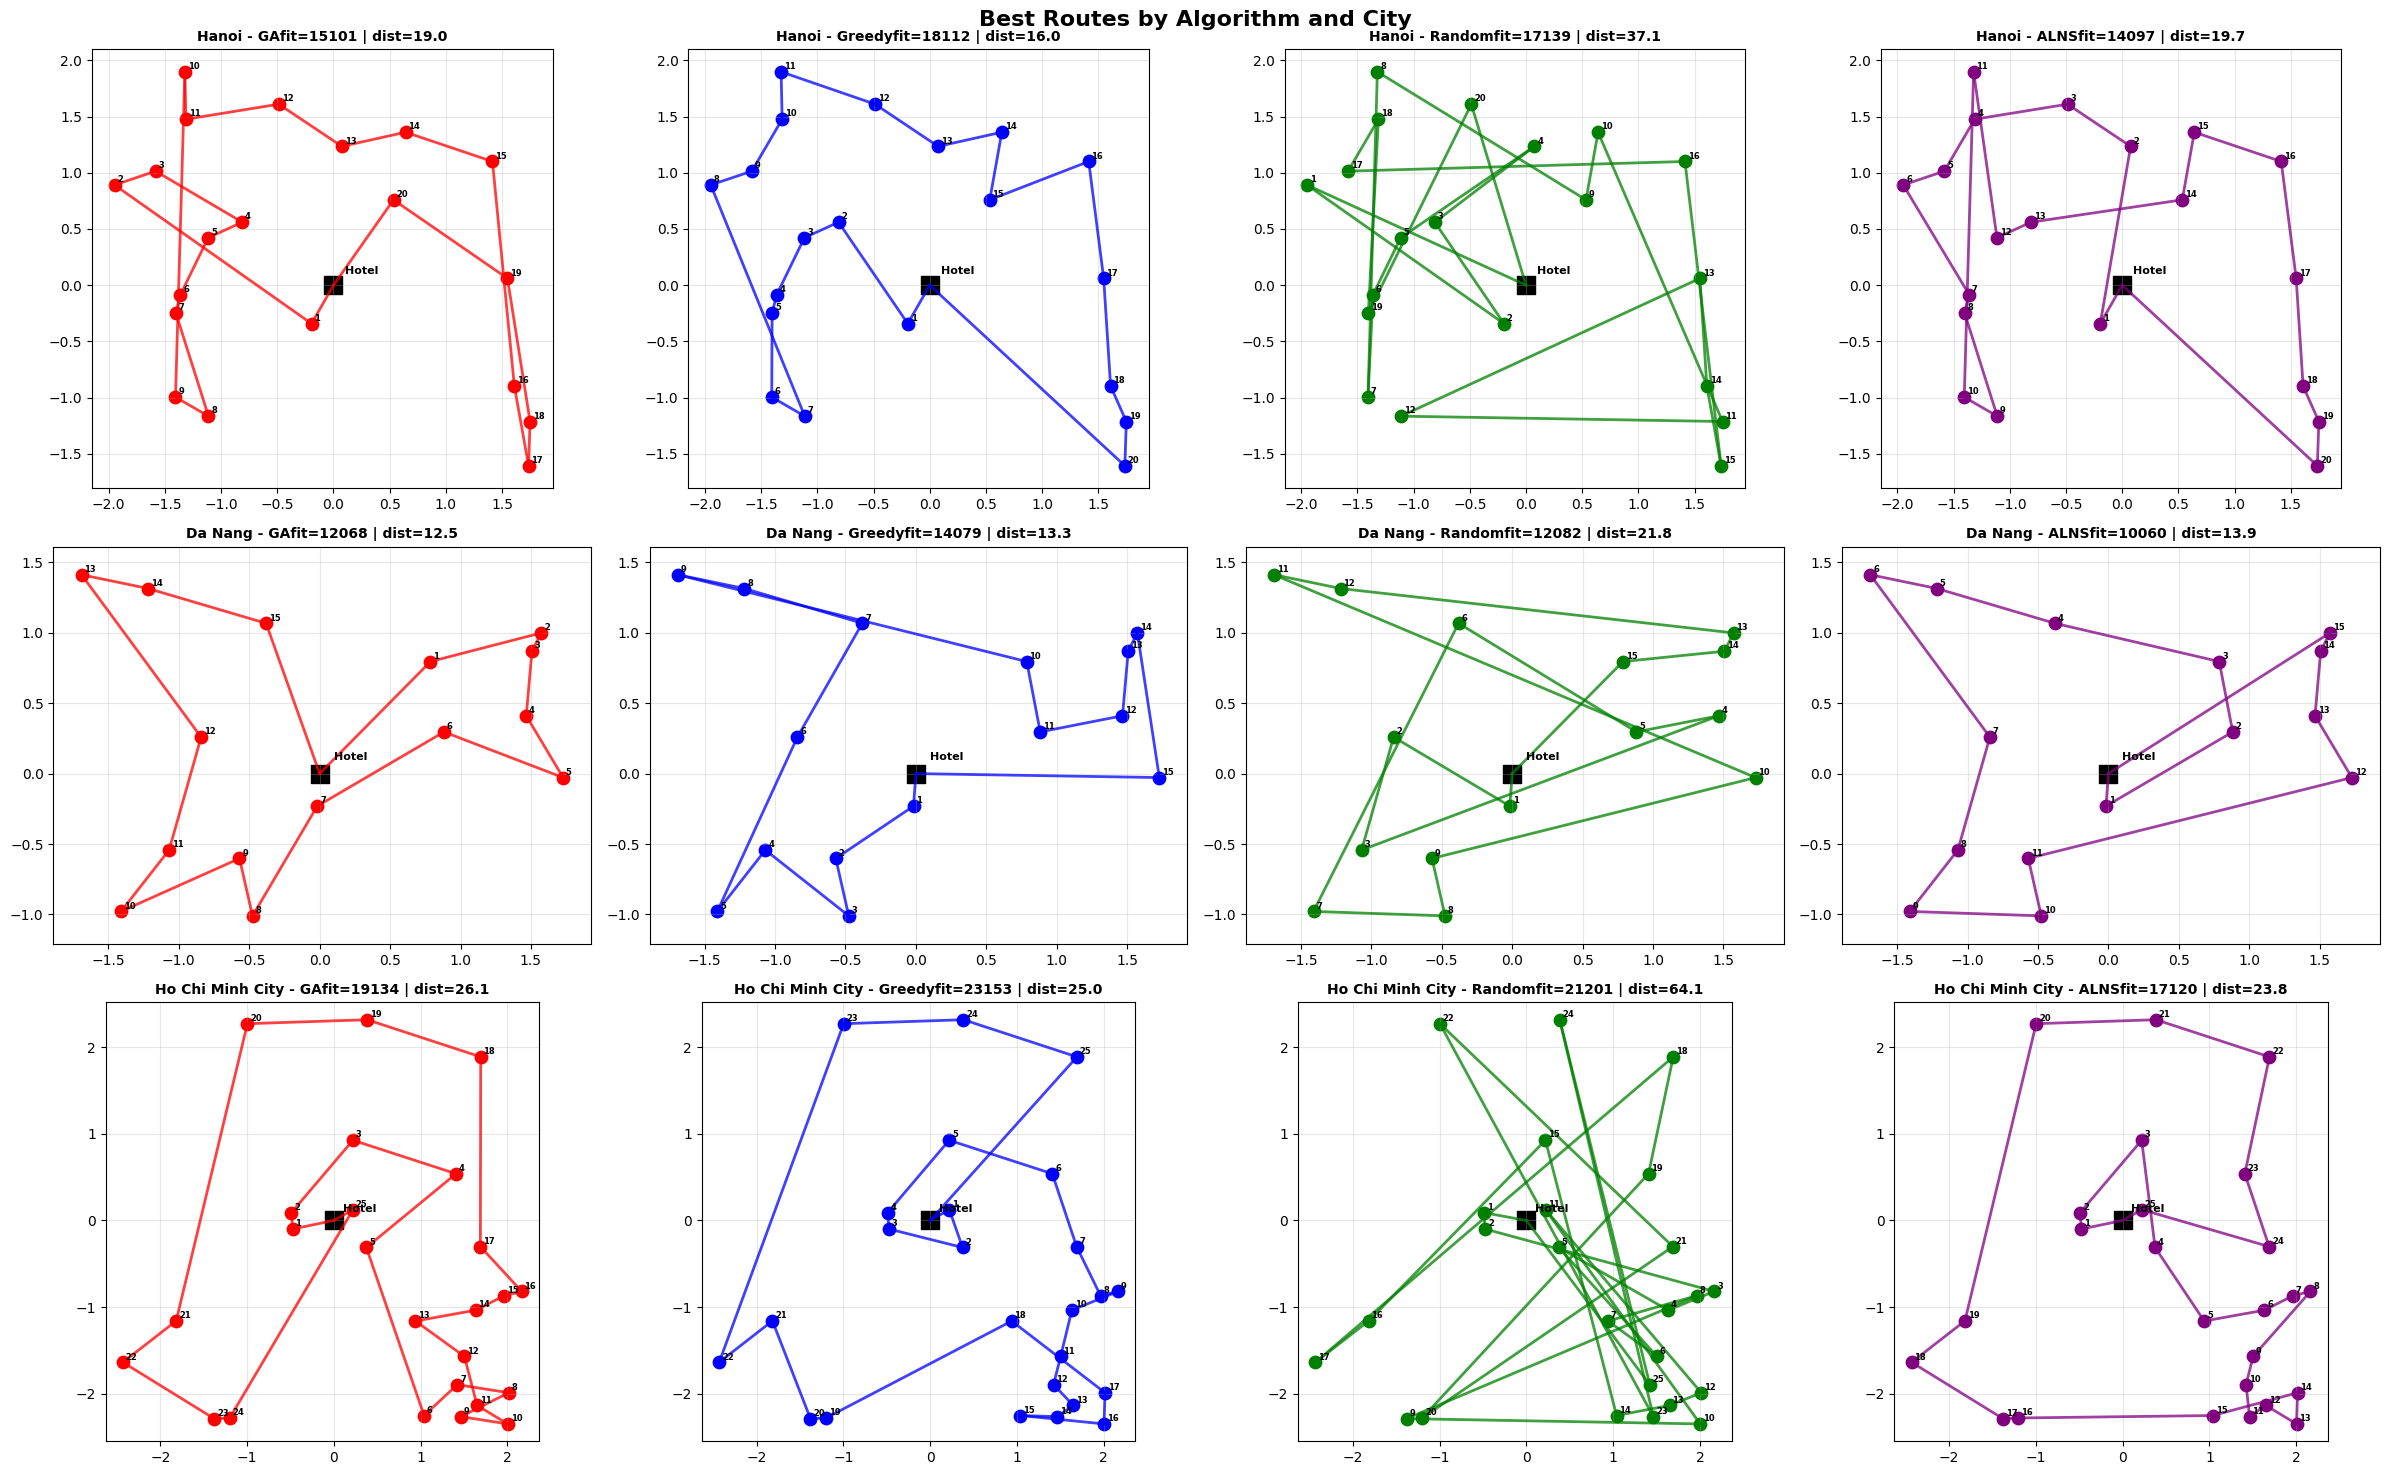

In [9]:

import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 4, figsize=(24, 15))
fig.suptitle('Best Routes by Algorithm and City', fontsize=16, fontweight='bold')
city_order=['Hanoi','Da Nang','Ho Chi Minh City']; alg_order=['GA','Greedy','Random','ALNS']; colors={'GA':'red','Greedy':'blue','Random':'green','ALNS':'purple'}
city_to_df={'Hanoi':hanoi_df,'Da Nang':danang_df,'Ho Chi Minh City':hcmc_df}
for i, city in enumerate(city_order):
    df = city_to_df[city]
    for j, alg in enumerate(alg_order):
        ax=axes[i,j]; ax.scatter(0,0,c='black',s=180,marker='s'); ax.annotate('Hotel',(0,0),xytext=(0.1,0.1),fontsize=8,fontweight='bold')
        ax.scatter(df['x'], df['y'], c='lightgray', s=40, alpha=0.6)
        route = comparison_results[city][alg]['best_route']
        if route:
            coords=[(0,0)]
            for aid in route:
                r=df[df['id']==aid].iloc[0]; coords.append((r['x'],r['y']))
            coords.append((0,0))
            for k in range(len(coords)-1):
                ax.plot([coords[k][0],coords[k+1][0]],[coords[k][1],coords[k+1][1]],c=colors[alg],lw=2,alpha=0.75)
            for idx, aid in enumerate(route):
                r=df[df['id']==aid].iloc[0]
                ax.scatter(r['x'],r['y'],c=colors[alg],s=80)
                ax.annotate(f'{idx+1}', (r['x'],r['y']), xytext=(2,2), textcoords='offset points', fontsize=6, fontweight='bold')
        det=comparison_results[city][alg]['best_details']
        ax.set_title(f"{city} - {alg}fit={det['fitness']:.0f} | dist={det['total_dist']:.1f}", fontsize=10, fontweight='bold')
        ax.grid(True, alpha=0.3); ax.set_aspect('equal')
        m=0.2; ax.set_xlim(df['x'].min()-m, df['x'].max()+m); ax.set_ylim(df['y'].min()-m, df['y'].max()+m)
plt.tight_layout(); plt.savefig('tourist_route_visualizations.png', dpi=300, bbox_inches='tight')
print('Saved tourist_route_visualizations.png')


## Statistical Analysis & Scalability

In [10]:

# Algorithm summary
algo_summary = comparison_df.groupby('Algorithm').agg({'Fitness_Score':['mean','std','min'],'Total_Distance':['mean','std'],'Execution_Time':['mean','std'],'Attractions_Visited':'mean'}).round(3)
print(algo_summary)
# City summary
city_summary = comparison_df.groupby('City').agg({'Fitness_Score':['mean','min'],'Total_Distance':'mean','Total_Cost':'mean','Attractions_Visited':'mean'}).round(2)
print('',city_summary)
# Scalability & correlation
sc_rows=[]; sizes={'Hanoi':len(hanoi_df),'Da Nang':len(danang_df),'Ho Chi Minh City':len(hcmc_df)}
for city in comparison_df['City'].unique():
    sub=comparison_df[comparison_df['City']==city]; size=sizes[city]
    for alg in comparison_df['Algorithm'].unique():
        s=sub[sub['Algorithm']==alg]
        if not s.empty:
            sc_rows.append({'Algorithm':alg,'Dataset_Size':size,'Avg_Fitness':s['Fitness_Score'].mean(),'Avg_Execution_Time':s['Execution_Time'].mean(),'Fitness_Per_Attraction':s['Fitness_Score'].mean()/size,'Time_Per_Attraction':(s['Execution_Time'].mean()/size) if s['Execution_Time'].mean()>0 else 0})
scalability_df=pd.DataFrame(sc_rows)
scalability_df.to_csv('scalability_analysis.csv', index=False)
correlation = comparison_df[['Fitness_Score','Total_Distance','Total_Cost','Execution_Time','Attractions_Visited']].corr().round(3)
correlation.to_csv('correlation_matrix.csv')
print('Saved scalability_analysis.csv and correlation_matrix.csv')


          Fitness_Score                      Total_Distance          \
                   mean       std        min           mean     std   
Algorithm                                                             
ALNS          13759.197  3542.417  10059.816         19.101   4.993   
GA            15434.349  3544.734  12067.854         19.203   6.770   
Greedy        18447.995  4546.376  14078.986         18.106   6.129   
Random        16807.068  4568.607  12081.746         41.016  21.433   

          Execution_Time        Attractions_Visited  
                    mean    std                mean  
Algorithm                                            
ALNS               2.036  1.602                20.0  
GA                 0.057  0.018                20.0  
Greedy             0.000  0.000                20.0  
Random             0.017  0.004                20.0  
                  Fitness_Score           Total_Distance Total_Cost  \
                          mean       min           me

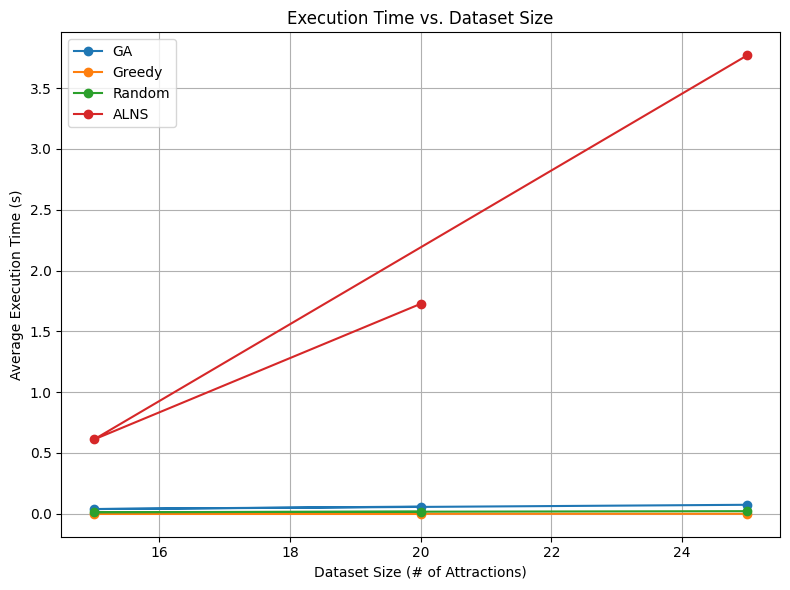

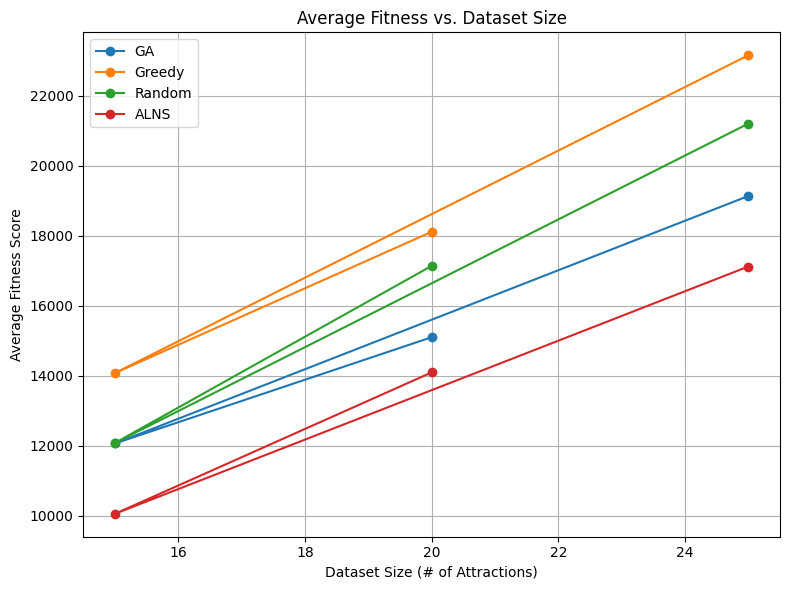

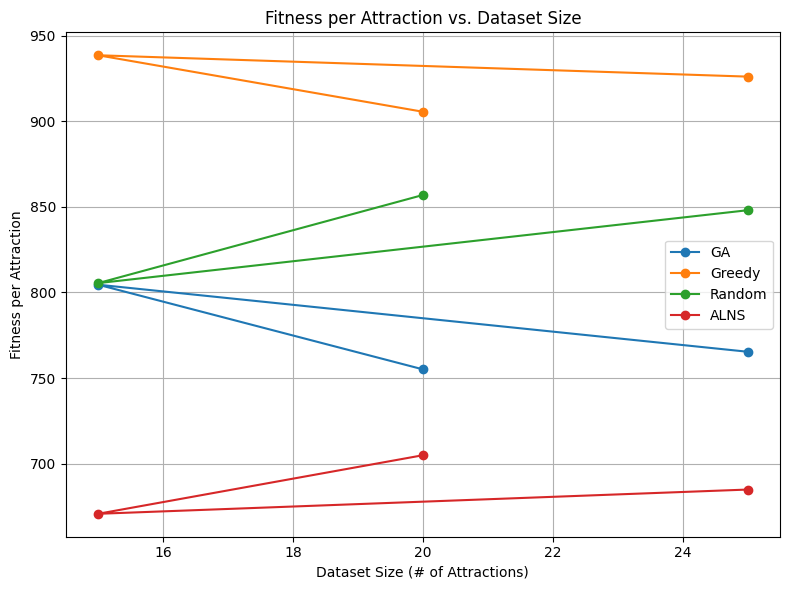

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("results/scalability_analysis.csv")

# Plot Execution Time vs Dataset Size
plt.figure(figsize=(8,6))
for algo in df['Algorithm'].unique():
    subset = df[df['Algorithm'] == algo]
    plt.plot(subset['Dataset_Size'], subset['Avg_Execution_Time'],
             marker='o', label=algo)
plt.xlabel("Dataset Size (# of Attractions)")
plt.ylabel("Average Execution Time (s)")
plt.title("Execution Time vs. Dataset Size")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Average Fitness vs Dataset Size
plt.figure(figsize=(8,6))
for algo in df['Algorithm'].unique():
    subset = df[df['Algorithm'] == algo]
    plt.plot(subset['Dataset_Size'], subset['Avg_Fitness'],
             marker='o', label=algo)
plt.xlabel("Dataset Size (# of Attractions)")
plt.ylabel("Average Fitness Score")
plt.title("Average Fitness vs. Dataset Size")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Fitness per Attraction (optional)
plt.figure(figsize=(8,6))
for algo in df['Algorithm'].unique():
    subset = df[df['Algorithm'] == algo]
    plt.plot(subset['Dataset_Size'], subset['Fitness_Per_Attraction'],
             marker='o', label=algo)
plt.xlabel("Dataset Size (# of Attractions)")
plt.ylabel("Fitness per Attraction")
plt.title("Fitness per Attraction vs. Dataset Size")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


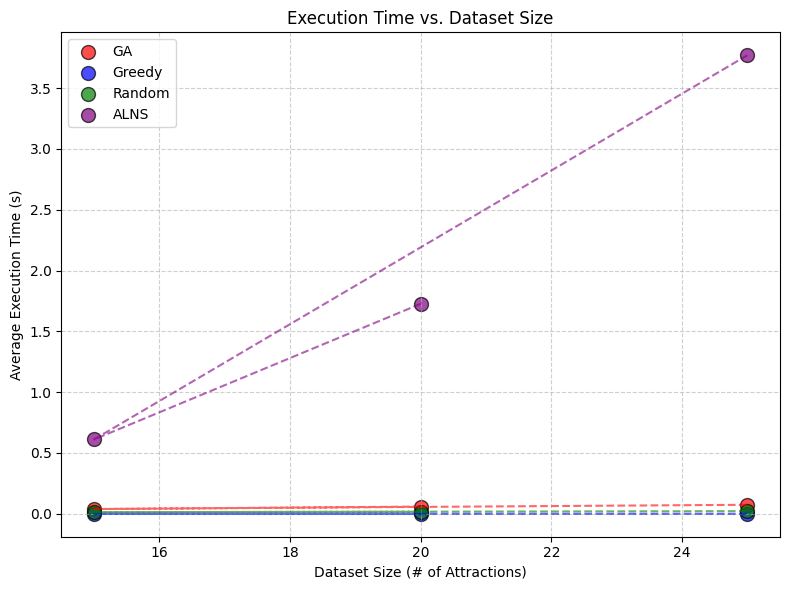

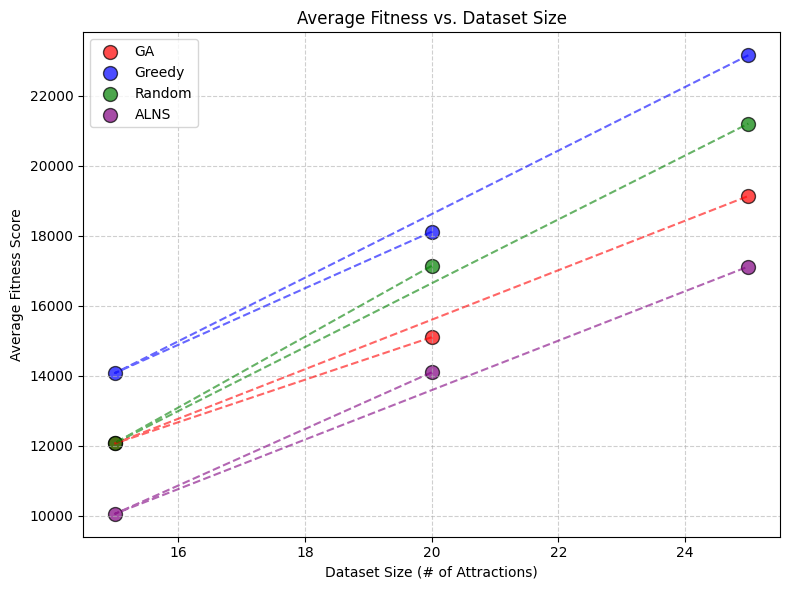

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
# df = pd.read_csv("scalability_analysis.csv")

algos = df['Algorithm'].unique()
colors = ['red', 'blue', 'green', 'purple']

# Scatter plot: Execution Time vs Dataset Size
plt.figure(figsize=(8,6))
for algo, color in zip(algos, colors):
    subset = df[df['Algorithm'] == algo]
    plt.scatter(subset['Dataset_Size'], subset['Avg_Execution_Time'],
                color=color, label=algo, s=100, alpha=0.7, edgecolor='k')
    plt.plot(subset['Dataset_Size'], subset['Avg_Execution_Time'],
             color=color, linestyle='--', alpha=0.6)  # optional trend line
plt.xlabel("Dataset Size (# of Attractions)")
plt.ylabel("Average Execution Time (s)")
plt.title("Execution Time vs. Dataset Size")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Scatter plot: Average Fitness vs Dataset Size
plt.figure(figsize=(8,6))
for algo, color in zip(algos, colors):
    subset = df[df['Algorithm'] == algo]
    plt.scatter(subset['Dataset_Size'], subset['Avg_Fitness'],
                color=color, label=algo, s=100, alpha=0.7, edgecolor='k')
    plt.plot(subset['Dataset_Size'], subset['Avg_Fitness'],
             color=color, linestyle='--', alpha=0.6)
plt.xlabel("Dataset Size (# of Attractions)")
plt.ylabel("Average Fitness Score")
plt.title("Average Fitness vs. Dataset Size")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


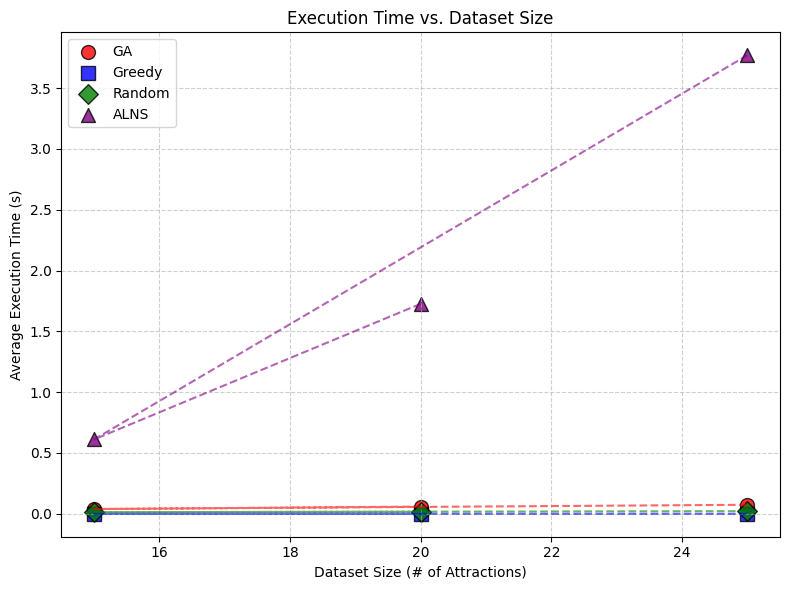

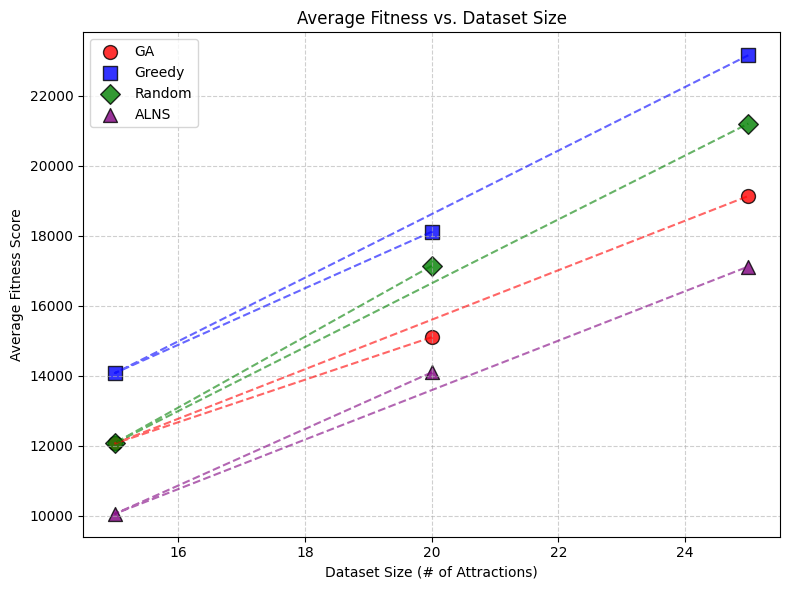

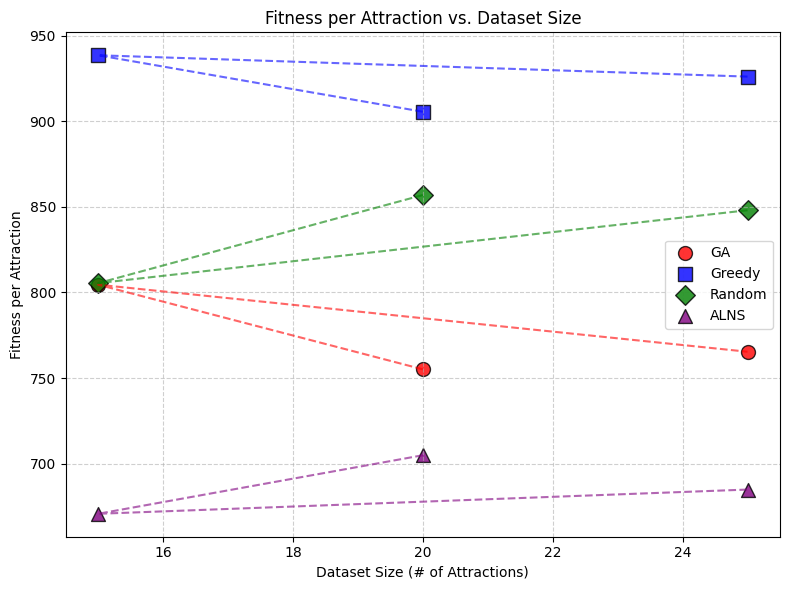

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
# df = pd.read_csv("scalability_analysis.csv")

# Define style
algos = df['Algorithm'].unique()
colors = ['red', 'blue', 'green', 'purple']
markers = ['o', 's', 'D', '^']

# 1. Execution Time vs Dataset Size
plt.figure(figsize=(8,6))
for algo, color, marker in zip(algos, colors, markers):
    subset = df[df['Algorithm'] == algo]
    plt.scatter(subset['Dataset_Size'], subset['Avg_Execution_Time'],
                color=color, marker=marker, s=100, alpha=0.8, edgecolor='k', label=algo)
    plt.plot(subset['Dataset_Size'], subset['Avg_Execution_Time'],
             color=color, linestyle='--', alpha=0.6)
plt.xlabel("Dataset Size (# of Attractions)")
plt.ylabel("Average Execution Time (s)")
plt.title("Execution Time vs. Dataset Size")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 2. Average Fitness vs Dataset Size
plt.figure(figsize=(8,6))
for algo, color, marker in zip(algos, colors, markers):
    subset = df[df['Algorithm'] == algo]
    plt.scatter(subset['Dataset_Size'], subset['Avg_Fitness'],
                color=color, marker=marker, s=100, alpha=0.8, edgecolor='k', label=algo)
    plt.plot(subset['Dataset_Size'], subset['Avg_Fitness'],
             color=color, linestyle='--', alpha=0.6)
plt.xlabel("Dataset Size (# of Attractions)")
plt.ylabel("Average Fitness Score")
plt.title("Average Fitness vs. Dataset Size")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 3. Fitness per Attraction vs Dataset Size
plt.figure(figsize=(8,6))
for algo, color, marker in zip(algos, colors, markers):
    subset = df[df['Algorithm'] == algo]
    plt.scatter(subset['Dataset_Size'], subset['Fitness_Per_Attraction'],
                color=color, marker=marker, s=100, alpha=0.8, edgecolor='k', label=algo)
    plt.plot(subset['Dataset_Size'], subset['Fitness_Per_Attraction'],
             color=color, linestyle='--', alpha=0.6)
plt.xlabel("Dataset Size (# of Attractions)")
plt.ylabel("Fitness per Attraction")
plt.title("Fitness per Attraction vs. Dataset Size")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


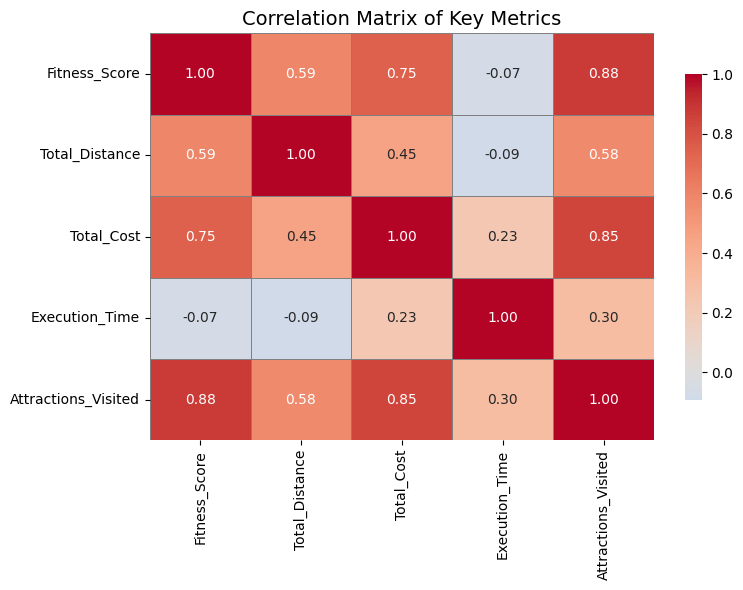

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the correlation matrix CSV
df = pd.read_csv("results/correlation_matrix.csv", index_col=0)

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df, annot=True, cmap="coolwarm", center=0, fmt=".2f",
            cbar_kws={"shrink": .8}, linewidths=0.5, linecolor="gray")
plt.title("Correlation Matrix of Key Metrics", fontsize=14)
plt.tight_layout()
plt.savefig("correlation_heatmap.png", dpi=300)
plt.show()
